In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge
from sklearn import neural_network
from sklearn.metrics import mean_squared_error
import skpp

from multiprocessing import Lock, Manager
from multiprocessing.pool import Pool
from multiprocessing import cpu_count
import time

import seaborn



### first step: generate data ###

In [2]:
d  = 20
test_size = 4000
nrep = 10
beta = np.random.randn(d)

In [3]:
def getRandomSamplesOnNSphere(N , numberOfSamples, R = 1):
    X = np.random.default_rng().normal(size=(numberOfSamples , N))
    return R / np.sqrt(np.sum(X**2, 1, keepdims=True)) * X

In [4]:
def generate_y(x,beta):
    # x is numpy array with (n,d) ,beta is (d) and fixed
    N = x.shape[0]
    d = x.shape[1]
    e = np.random.normal(0, 0.5,size = N)
    vector = np.einsum('i,ij -> j', beta,x.T)
    fx = np.sqrt(4/10)*vector + np.sqrt(4/10)*(np.sqrt(1/2)*(vector**2-1))+ \
        np.sqrt(2/10)*(np.sqrt(1/10)*(vector**4 - 6*vector**2 + 3))
    y = fx + e
    return y

### second step: model ###

In [5]:
class dataset(Dataset):
    def __init__(self, data_tensor, data_target):
        self.data_target = data_target
        self.data_tensor = data_tensor 
    
    def __len__(self):
        return self.data_target.shape[0]

    def __getitem__(self, index):
        return self.data_tensor[index], self.data_target[index]



In [6]:
class Model_1(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_1,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(self.hidden_dim,1)

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)
        out = self.linear2(x_signal)

        return out

In [21]:
class Model_2(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_2,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim,bias=False)
        self.act = nn.ReLU()

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)

        out = x_signal @ torch.FloatTensor([[1 if x%2==0 else -1 for x in range(x_signal.shape[1])]]).T

        return out

In [ ]:

result_trainingerror = np.zeros((60,40))
result_testerror = np.zeros((60,40))    

for i in range(20,80):
    x_id = i /20
    for j in range(20,60):
        y_id = j/20
        
        N = int(np.ceil(np.e**(y_id * np.log(20))))
        Nd = int(np.ceil(np.e**(x_id* np.log(20))))
        LOSS_train = 0
        LOSS_test = 0
        
        for nrepitition in range(nrep):
            x_train = getRandomSamplesOnNSphere(d,N)
            y_train = generate_y(x_train,beta)

            x_test = getRandomSamplesOnNSphere(d,test_size)
            y_test = generate_y(x_test,beta)
            
            nnr = neural_network.MLPRegressor(hidden_layer_sizes=(int(np.ceil(Nd/d))),learning_rate_init=0.01,\
                                             max_iter=500)
            nnr.fit(x_train,y_train)
            loss_train = mean_squared_error(y_train, nnr.predict(x_train))         
            
            LOSS_train += loss_train

            loss_test = mean_squared_error(y_test, nnr.predict(x_test))
            
            LOSS_test += loss_test
            
        training_error = LOSS_train /nrep
        test_error = LOSS_test /nrep
        
        result_trainingerror[i-20][j-20] = training_error
        result_testerror[i-20][j-20] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./ppr&nnr result/trainingerror.npy',result_trainingerror)
    np.save('./ppr&nnr result/testerror.npy',result_testerror)    
         


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 20,trainingerror: 0.363366, testerror: 1.293044
Nd: 20, N: 24,trainingerror: 0.370348, testerror: 1.040850


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 27,trainingerror: 0.263967, testerror: 1.511231
Nd: 20, N: 32,trainingerror: 0.419383, testerror: 1.484614
Nd: 20, N: 37,trainingerror: 0.334996, testerror: 0.933230


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 43,trainingerror: 0.392479, testerror: 1.170895
Nd: 20, N: 50,trainingerror: 0.378210, testerror: 0.941411


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 58,trainingerror: 0.488688, testerror: 0.862188
Nd: 20, N: 67,trainingerror: 0.461434, testerror: 0.947193
Nd: 20, N: 78,trainingerror: 0.675755, testerror: 0.797995
Nd: 20, N: 90,trainingerror: 0.432399, testerror: 0.794126


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 104,trainingerror: 0.364891, testerror: 0.736844


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 121,trainingerror: 0.468209, testerror: 0.702435


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 141,trainingerror: 0.448155, testerror: 0.615726
Nd: 20, N: 163,trainingerror: 0.430130, testerror: 0.681207


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 190,trainingerror: 0.448976, testerror: 0.576608
Nd: 20, N: 220,trainingerror: 0.506739, testerror: 0.661256


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 256,trainingerror: 0.485109, testerror: 0.607797


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 297,trainingerror: 0.438916, testerror: 0.537007


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 345,trainingerror: 0.557728, testerror: 0.574723
Nd: 20, N: 400,trainingerror: 0.519359, testerror: 0.576048


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 20, N: 465,trainingerror: 0.560415, testerror: 0.610640
Nd: 20, N: 540,trainingerror: 0.634111, testerror: 0.615414
Nd: 20, N: 627,trainingerror: 0.580545, testerror: 0.557627
Nd: 20, N: 729,trainingerror: 0.555109, testerror: 0.564610
Nd: 20, N: 846,trainingerror: 0.538157, testerror: 0.515379
Nd: 20, N: 983,trainingerror: 0.495651, testerror: 0.514872
Nd: 20, N: 1142,trainingerror: 0.461303, testerror: 0.510566
Nd: 20, N: 1326,trainingerror: 0.544830, testerror: 0.552209
Nd: 20, N: 1541,trainingerror: 0.512148, testerror: 0.524810
Nd: 20, N: 1789,trainingerror: 0.555276, testerror: 0.574754
Nd: 20, N: 2078,trainingerror: 0.521174, testerror: 0.525400
Nd: 20, N: 2414,trainingerror: 0.543270, testerror: 0.557176
Nd: 20, N: 2804,trainingerror: 0.578121, testerror: 0.538632
Nd: 20, N: 3257,trainingerror: 0.668897, testerror: 0.671951
Nd: 20, N: 3783,trainingerror: 0.524901, testerror: 0.501345
Nd: 20, N: 4395,trainingerror: 0.521533, testerror: 0.532338
Nd: 20, N: 5105,trainingerror:

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 32,trainingerror: 0.199376, testerror: 1.110672
Nd: 24, N: 37,trainingerror: 0.254471, testerror: 0.935586
Nd: 24, N: 43,trainingerror: 0.189439, testerror: 0.930448
Nd: 24, N: 50,trainingerror: 0.132229, testerror: 1.045947


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 58,trainingerror: 0.181598, testerror: 0.926633
Nd: 24, N: 67,trainingerror: 0.217464, testerror: 0.903612


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 78,trainingerror: 0.286527, testerror: 0.961570


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/m

Nd: 24, N: 90,trainingerror: 0.326362, testerror: 0.798033
Nd: 24, N: 104,trainingerror: 0.369754, testerror: 0.882940


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 121,trainingerror: 0.436769, testerror: 0.851378


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 141,trainingerror: 0.271587, testerror: 0.795586
Nd: 24, N: 163,trainingerror: 0.324028, testerror: 0.628651


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 190,trainingerror: 0.343959, testerror: 0.633150
Nd: 24, N: 220,trainingerror: 0.430432, testerror: 0.616133
Nd: 24, N: 256,trainingerror: 0.401053, testerror: 0.634412


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 297,trainingerror: 0.504854, testerror: 0.650608


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 345,trainingerror: 0.488376, testerror: 0.608105


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 400,trainingerror: 0.411224, testerror: 0.563496


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 24, N: 465,trainingerror: 0.423740, testerror: 0.540413
Nd: 24, N: 540,trainingerror: 0.371177, testerror: 0.514721
Nd: 24, N: 627,trainingerror: 0.402871, testerror: 0.534676
Nd: 24, N: 729,trainingerror: 0.498069, testerror: 0.555296
Nd: 24, N: 846,trainingerror: 0.494258, testerror: 0.512508
Nd: 24, N: 983,trainingerror: 0.426437, testerror: 0.497835
Nd: 24, N: 1142,trainingerror: 0.504131, testerror: 0.511573
Nd: 24, N: 1326,trainingerror: 0.506555, testerror: 0.505855
Nd: 24, N: 1541,trainingerror: 0.459433, testerror: 0.466836
Nd: 24, N: 1789,trainingerror: 0.434612, testerror: 0.452162
Nd: 24, N: 2078,trainingerror: 0.481799, testerror: 0.505992
Nd: 24, N: 2414,trainingerror: 0.505180, testerror: 0.482358
Nd: 24, N: 2804,trainingerror: 0.450703, testerror: 0.497196
Nd: 24, N: 3257,trainingerror: 0.441398, testerror: 0.436992
Nd: 24, N: 3783,trainingerror: 0.471156, testerror: 0.472527
Nd: 24, N: 4395,trainingerror: 0.479157, testerror: 0.464788
Nd: 24, N: 5105,trainingerror:

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 20,trainingerror: 0.293112, testerror: 3.672260
Nd: 27, N: 24,trainingerror: 0.178159, testerror: 1.024329
Nd: 27, N: 27,trainingerror: 0.166845, testerror: 1.077923


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 32,trainingerror: 0.099778, testerror: 1.042403
Nd: 27, N: 37,trainingerror: 0.135770, testerror: 1.140756
Nd: 27, N: 43,trainingerror: 0.059657, testerror: 1.433050


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 50,trainingerror: 0.196416, testerror: 1.561595
Nd: 27, N: 58,trainingerror: 0.448094, testerror: 0.921878
Nd: 27, N: 67,trainingerror: 0.277420, testerror: 1.373199


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 78,trainingerror: 0.269765, testerror: 0.962233


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 90,trainingerror: 0.206978, testerror: 0.783068


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 104,trainingerror: 0.283715, testerror: 0.804833
Nd: 27, N: 121,trainingerror: 0.287651, testerror: 0.779012
Nd: 27, N: 141,trainingerror: 0.351811, testerror: 0.707445
Nd: 27, N: 163,trainingerror: 0.302551, testerror: 0.699549
Nd: 27, N: 190,trainingerror: 0.368953, testerror: 0.614977
Nd: 27, N: 220,trainingerror: 0.467863, testerror: 0.635205


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 256,trainingerror: 0.391913, testerror: 0.634218


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 297,trainingerror: 0.434602, testerror: 0.607039
Nd: 27, N: 345,trainingerror: 0.418140, testerror: 0.618078


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 27, N: 400,trainingerror: 0.390050, testerror: 0.548551
Nd: 27, N: 465,trainingerror: 0.433024, testerror: 0.517149
Nd: 27, N: 540,trainingerror: 0.450195, testerror: 0.561855
Nd: 27, N: 627,trainingerror: 0.454513, testerror: 0.551922
Nd: 27, N: 729,trainingerror: 0.414155, testerror: 0.509141
Nd: 27, N: 846,trainingerror: 0.484691, testerror: 0.499227
Nd: 27, N: 983,trainingerror: 0.453545, testerror: 0.545753
Nd: 27, N: 1142,trainingerror: 0.443272, testerror: 0.485808
Nd: 27, N: 1326,trainingerror: 0.490622, testerror: 0.504823
Nd: 27, N: 1541,trainingerror: 0.465535, testerror: 0.486149
Nd: 27, N: 1789,trainingerror: 0.570073, testerror: 0.549015
Nd: 27, N: 2078,trainingerror: 0.433560, testerror: 0.464089
Nd: 27, N: 2414,trainingerror: 0.442256, testerror: 0.484398
Nd: 27, N: 2804,trainingerror: 0.490609, testerror: 0.492407
Nd: 27, N: 3257,trainingerror: 0.504451, testerror: 0.524966
Nd: 27, N: 3783,trainingerror: 0.421965, testerror: 0.426433
Nd: 27, N: 4395,trainingerror: 

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 20,trainingerror: 0.240121, testerror: 1.726661
Nd: 32, N: 24,trainingerror: 0.165730, testerror: 1.304625


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 27,trainingerror: 0.110638, testerror: 1.329657
Nd: 32, N: 32,trainingerror: 0.258881, testerror: 0.975274


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 37,trainingerror: 0.106879, testerror: 1.222387
Nd: 32, N: 43,trainingerror: 0.158490, testerror: 1.208204


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 50,trainingerror: 0.152934, testerror: 1.070782


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 58,trainingerror: 0.242440, testerror: 1.118959


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 67,trainingerror: 0.271340, testerror: 1.083471
Nd: 32, N: 78,trainingerror: 0.242693, testerror: 1.053957
Nd: 32, N: 90,trainingerror: 0.266264, testerror: 0.951817


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 104,trainingerror: 0.438411, testerror: 0.723953


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 121,trainingerror: 0.256913, testerror: 0.685327
Nd: 32, N: 141,trainingerror: 0.311650, testerror: 0.626548


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 163,trainingerror: 0.445659, testerror: 0.702602
Nd: 32, N: 190,trainingerror: 0.340700, testerror: 0.609485
Nd: 32, N: 220,trainingerror: 0.448511, testerror: 0.627496
Nd: 32, N: 256,trainingerror: 0.406990, testerror: 0.615626


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 297,trainingerror: 0.375197, testerror: 0.558722
Nd: 32, N: 345,trainingerror: 0.432113, testerror: 0.540828
Nd: 32, N: 400,trainingerror: 0.413629, testerror: 0.580928


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 465,trainingerror: 0.479802, testerror: 0.551749
Nd: 32, N: 540,trainingerror: 0.449733, testerror: 0.497639
Nd: 32, N: 627,trainingerror: 0.439643, testerror: 0.524515
Nd: 32, N: 729,trainingerror: 0.481609, testerror: 0.519016


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 32, N: 846,trainingerror: 0.451943, testerror: 0.497824
Nd: 32, N: 983,trainingerror: 0.438298, testerror: 0.506187
Nd: 32, N: 1142,trainingerror: 0.491066, testerror: 0.525727
Nd: 32, N: 1326,trainingerror: 0.436563, testerror: 0.474119
Nd: 32, N: 1541,trainingerror: 0.488461, testerror: 0.525873
Nd: 32, N: 1789,trainingerror: 0.412558, testerror: 0.471821
Nd: 32, N: 2078,trainingerror: 0.491177, testerror: 0.503284
Nd: 32, N: 2414,trainingerror: 0.444617, testerror: 0.514268
Nd: 32, N: 2804,trainingerror: 0.426082, testerror: 0.456124
Nd: 32, N: 3257,trainingerror: 0.464087, testerror: 0.456842
Nd: 32, N: 3783,trainingerror: 0.393061, testerror: 0.424115
Nd: 32, N: 4395,trainingerror: 0.451398, testerror: 0.475921
Nd: 32, N: 5105,trainingerror: 0.465370, testerror: 0.473424
Nd: 32, N: 5930,trainingerror: 0.492662, testerror: 0.520798
Nd: 32, N: 6888,trainingerror: 0.476949, testerror: 0.470861
Nd: 37, N: 20,trainingerror: 0.073707, testerror: 1.223173
Nd: 37, N: 24,trainingerror:

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 37,trainingerror: 0.074097, testerror: 1.027359
Nd: 37, N: 43,trainingerror: 0.456927, testerror: 0.985038


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 50,trainingerror: 0.299479, testerror: 1.748896


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 58,trainingerror: 0.237875, testerror: 1.132536


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 67,trainingerror: 0.284635, testerror: 0.975402
Nd: 37, N: 78,trainingerror: 0.286404, testerror: 0.868493
Nd: 37, N: 90,trainingerror: 0.272348, testerror: 0.896283
Nd: 37, N: 104,trainingerror: 0.295069, testerror: 0.704736


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 121,trainingerror: 0.224508, testerror: 0.892483
Nd: 37, N: 141,trainingerror: 0.512323, testerror: 0.780701


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 163,trainingerror: 0.267756, testerror: 0.701790
Nd: 37, N: 190,trainingerror: 0.601907, testerror: 0.667620
Nd: 37, N: 220,trainingerror: 0.346174, testerror: 0.612137
Nd: 37, N: 256,trainingerror: 0.491659, testerror: 0.561886


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 297,trainingerror: 0.410030, testerror: 0.586695


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 345,trainingerror: 0.518103, testerror: 0.579585
Nd: 37, N: 400,trainingerror: 0.461446, testerror: 0.606026
Nd: 37, N: 465,trainingerror: 0.506242, testerror: 0.563476


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 540,trainingerror: 0.358318, testerror: 0.508475
Nd: 37, N: 627,trainingerror: 0.424662, testerror: 0.515122
Nd: 37, N: 729,trainingerror: 0.425782, testerror: 0.510380


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 37, N: 846,trainingerror: 0.550110, testerror: 0.509401
Nd: 37, N: 983,trainingerror: 0.422069, testerror: 0.482372
Nd: 37, N: 1142,trainingerror: 0.426870, testerror: 0.548207
Nd: 37, N: 1326,trainingerror: 0.558614, testerror: 0.504980
Nd: 37, N: 1541,trainingerror: 0.454124, testerror: 0.499740
Nd: 37, N: 1789,trainingerror: 0.536349, testerror: 0.519801
Nd: 37, N: 2078,trainingerror: 0.452119, testerror: 0.514097
Nd: 37, N: 2414,trainingerror: 0.465446, testerror: 0.508699
Nd: 37, N: 2804,trainingerror: 0.427455, testerror: 0.491204
Nd: 37, N: 3257,trainingerror: 0.443263, testerror: 0.478524
Nd: 37, N: 3783,trainingerror: 0.546100, testerror: 0.493108
Nd: 37, N: 4395,trainingerror: 0.431877, testerror: 0.460541
Nd: 37, N: 5105,trainingerror: 0.448413, testerror: 0.454113
Nd: 37, N: 5930,trainingerror: 0.429580, testerror: 0.447009
Nd: 37, N: 6888,trainingerror: 0.443321, testerror: 0.460196


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 20,trainingerror: 0.055131, testerror: 1.343760
Nd: 43, N: 24,trainingerror: 0.017493, testerror: 1.107925


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 27,trainingerror: 0.036337, testerror: 1.198390
Nd: 43, N: 32,trainingerror: 0.047292, testerror: 1.025048


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 37,trainingerror: 0.102949, testerror: 1.222108
Nd: 43, N: 43,trainingerror: 0.044685, testerror: 1.269676


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 50,trainingerror: 0.052075, testerror: 1.298574


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 58,trainingerror: 0.243466, testerror: 1.023483


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 67,trainingerror: 0.151775, testerror: 1.388229
Nd: 43, N: 78,trainingerror: 0.098003, testerror: 0.907944
Nd: 43, N: 90,trainingerror: 0.118576, testerror: 0.991623


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 104,trainingerror: 0.214115, testerror: 0.882077


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 121,trainingerror: 0.214015, testerror: 0.789742


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 141,trainingerror: 0.231489, testerror: 0.827670
Nd: 43, N: 163,trainingerror: 0.242223, testerror: 0.665595


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 190,trainingerror: 0.254102, testerror: 0.681713
Nd: 43, N: 220,trainingerror: 0.437986, testerror: 0.655128
Nd: 43, N: 256,trainingerror: 0.428125, testerror: 0.653334
Nd: 43, N: 297,trainingerror: 0.448416, testerror: 0.590572
Nd: 43, N: 345,trainingerror: 0.316395, testerror: 0.630509


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 43, N: 400,trainingerror: 0.353818, testerror: 0.606470
Nd: 43, N: 465,trainingerror: 0.348151, testerror: 0.560708
Nd: 43, N: 540,trainingerror: 0.378156, testerror: 0.608092
Nd: 43, N: 627,trainingerror: 0.430832, testerror: 0.512689
Nd: 43, N: 729,trainingerror: 0.394980, testerror: 0.520399
Nd: 43, N: 846,trainingerror: 0.357978, testerror: 0.513552
Nd: 43, N: 983,trainingerror: 0.345051, testerror: 0.464671
Nd: 43, N: 1142,trainingerror: 0.449700, testerror: 0.514071
Nd: 43, N: 1326,trainingerror: 0.392478, testerror: 0.430983
Nd: 43, N: 1541,trainingerror: 0.397812, testerror: 0.431026
Nd: 43, N: 1789,trainingerror: 0.453286, testerror: 0.480936
Nd: 43, N: 2078,trainingerror: 0.384700, testerror: 0.433901
Nd: 43, N: 2414,trainingerror: 0.459079, testerror: 0.463631
Nd: 43, N: 2804,trainingerror: 0.414906, testerror: 0.456165
Nd: 43, N: 3257,trainingerror: 0.401903, testerror: 0.402888
Nd: 43, N: 3783,trainingerror: 0.339097, testerror: 0.364238
Nd: 43, N: 4395,trainingerror: 

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 50, N: 43,trainingerror: 0.102054, testerror: 1.302311
Nd: 50, N: 50,trainingerror: 0.060904, testerror: 1.173579


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 50, N: 58,trainingerror: 0.142958, testerror: 1.202191


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 50, N: 67,trainingerror: 0.094366, testerror: 1.094646


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 50, N: 78,trainingerror: 0.118629, testerror: 1.023990
Nd: 50, N: 90,trainingerror: 0.168811, testerror: 1.007785
Nd: 50, N: 104,trainingerror: 0.179509, testerror: 1.048311
Nd: 50, N: 121,trainingerror: 0.216342, testerror: 0.983737


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 50, N: 141,trainingerror: 0.295817, testerror: 1.037649
Nd: 50, N: 163,trainingerror: 0.304335, testerror: 0.930442


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 50, N: 190,trainingerror: 0.374472, testerror: 0.740513


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 50, N: 220,trainingerror: 0.354431, testerror: 0.677241
Nd: 50, N: 256,trainingerror: 0.379653, testerror: 0.666295
Nd: 50, N: 297,trainingerror: 0.339777, testerror: 0.631504
Nd: 50, N: 345,trainingerror: 0.340543, testerror: 0.561890
Nd: 50, N: 400,trainingerror: 0.384436, testerror: 0.596574
Nd: 50, N: 465,trainingerror: 0.335647, testerror: 0.548135
Nd: 50, N: 540,trainingerror: 0.352943, testerror: 0.546195
Nd: 50, N: 627,trainingerror: 0.388655, testerror: 0.501147


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 50, N: 729,trainingerror: 0.432148, testerror: 0.519414
Nd: 50, N: 846,trainingerror: 0.402304, testerror: 0.494418
Nd: 50, N: 983,trainingerror: 0.360766, testerror: 0.468139
Nd: 50, N: 1142,trainingerror: 0.445115, testerror: 0.532519
Nd: 50, N: 1326,trainingerror: 0.433001, testerror: 0.492653
Nd: 50, N: 1541,trainingerror: 0.369612, testerror: 0.456491
Nd: 50, N: 1789,trainingerror: 0.420157, testerror: 0.477660
Nd: 50, N: 2078,trainingerror: 0.430867, testerror: 0.463682
Nd: 50, N: 2414,trainingerror: 0.464837, testerror: 0.462001
Nd: 50, N: 2804,trainingerror: 0.406255, testerror: 0.413477
Nd: 50, N: 3257,trainingerror: 0.434326, testerror: 0.442983
Nd: 50, N: 3783,trainingerror: 0.369131, testerror: 0.381630
Nd: 50, N: 4395,trainingerror: 0.374091, testerror: 0.379832
Nd: 50, N: 5105,trainingerror: 0.433080, testerror: 0.442686
Nd: 50, N: 5930,trainingerror: 0.429079, testerror: 0.442177
Nd: 50, N: 6888,trainingerror: 0.423407, testerror: 0.423130
Nd: 58, N: 20,trainingerror

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 24,trainingerror: 0.115570, testerror: 1.187911
Nd: 58, N: 27,trainingerror: 0.051919, testerror: 1.269889
Nd: 58, N: 32,trainingerror: 0.036741, testerror: 1.166720


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 37,trainingerror: 0.036218, testerror: 1.192720


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 43,trainingerror: 0.067028, testerror: 1.077522
Nd: 58, N: 50,trainingerror: 0.079234, testerror: 1.319663


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 58,trainingerror: 0.124351, testerror: 1.434356


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 67,trainingerror: 0.075751, testerror: 1.159849
Nd: 58, N: 78,trainingerror: 0.107584, testerror: 0.910187


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 90,trainingerror: 0.188257, testerror: 1.390731


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 104,trainingerror: 0.174006, testerror: 1.077690
Nd: 58, N: 121,trainingerror: 0.233061, testerror: 0.826142
Nd: 58, N: 141,trainingerror: 0.249980, testerror: 0.759998
Nd: 58, N: 163,trainingerror: 0.251802, testerror: 0.757166


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 190,trainingerror: 0.405446, testerror: 0.829418
Nd: 58, N: 220,trainingerror: 0.375112, testerror: 0.637052


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 256,trainingerror: 0.309906, testerror: 0.646746


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 297,trainingerror: 0.503783, testerror: 0.665035


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 345,trainingerror: 0.332646, testerror: 0.593507


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 400,trainingerror: 0.405827, testerror: 0.580658


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 465,trainingerror: 0.310428, testerror: 0.548392


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 540,trainingerror: 0.399962, testerror: 0.575819
Nd: 58, N: 627,trainingerror: 0.352372, testerror: 0.496721


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 729,trainingerror: 0.368426, testerror: 0.499981


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 58, N: 846,trainingerror: 0.397754, testerror: 0.471688
Nd: 58, N: 983,trainingerror: 0.444271, testerror: 0.533317
Nd: 58, N: 1142,trainingerror: 0.399714, testerror: 0.475042
Nd: 58, N: 1326,trainingerror: 0.421610, testerror: 0.464251
Nd: 58, N: 1541,trainingerror: 0.411154, testerror: 0.424494
Nd: 58, N: 1789,trainingerror: 0.340217, testerror: 0.396615
Nd: 58, N: 2078,trainingerror: 0.369967, testerror: 0.424401
Nd: 58, N: 2414,trainingerror: 0.435111, testerror: 0.477541
Nd: 58, N: 2804,trainingerror: 0.423440, testerror: 0.479089
Nd: 58, N: 3257,trainingerror: 0.421634, testerror: 0.429921
Nd: 58, N: 3783,trainingerror: 0.403193, testerror: 0.403978
Nd: 58, N: 4395,trainingerror: 0.384333, testerror: 0.409793
Nd: 58, N: 5105,trainingerror: 0.373592, testerror: 0.393575
Nd: 58, N: 5930,trainingerror: 0.445306, testerror: 0.440625
Nd: 58, N: 6888,trainingerror: 0.420620, testerror: 0.427175
Nd: 67, N: 20,trainingerror: 0.059946, testerror: 1.512363
Nd: 67, N: 24,trainingerror:

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 32,trainingerror: 0.021694, testerror: 0.978326


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 37,trainingerror: 0.268821, testerror: 1.423935
Nd: 67, N: 43,trainingerror: 0.023660, testerror: 1.033895
Nd: 67, N: 50,trainingerror: 0.051107, testerror: 0.960479


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 58,trainingerror: 0.027188, testerror: 1.208534
Nd: 67, N: 67,trainingerror: 0.032342, testerror: 1.132901
Nd: 67, N: 78,trainingerror: 0.083495, testerror: 1.109482


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 90,trainingerror: 0.086027, testerror: 0.985779
Nd: 67, N: 104,trainingerror: 0.086957, testerror: 0.938448


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 121,trainingerror: 0.168644, testerror: 0.937639
Nd: 67, N: 141,trainingerror: 0.193523, testerror: 0.944538


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 163,trainingerror: 0.191198, testerror: 0.922060


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 190,trainingerror: 0.224705, testerror: 0.789925


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 220,trainingerror: 0.274709, testerror: 0.659464


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 256,trainingerror: 0.254321, testerror: 0.744642


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 297,trainingerror: 0.281739, testerror: 0.648920
Nd: 67, N: 345,trainingerror: 0.278097, testerror: 0.625111
Nd: 67, N: 400,trainingerror: 0.341339, testerror: 0.586364
Nd: 67, N: 465,trainingerror: 0.335490, testerror: 0.577844
Nd: 67, N: 540,trainingerror: 0.390953, testerror: 0.624085
Nd: 67, N: 627,trainingerror: 0.351571, testerror: 0.546459
Nd: 67, N: 729,trainingerror: 0.312343, testerror: 0.516186


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 846,trainingerror: 0.367433, testerror: 0.472766


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 983,trainingerror: 0.348147, testerror: 0.440701


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 1142,trainingerror: 0.337987, testerror: 0.451988


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 67, N: 1326,trainingerror: 0.339591, testerror: 0.446172
Nd: 67, N: 1541,trainingerror: 0.338968, testerror: 0.380751
Nd: 67, N: 1789,trainingerror: 0.362581, testerror: 0.413090
Nd: 67, N: 2078,trainingerror: 0.309707, testerror: 0.365529
Nd: 67, N: 2414,trainingerror: 0.378580, testerror: 0.385433
Nd: 67, N: 2804,trainingerror: 0.423322, testerror: 0.452262
Nd: 67, N: 3257,trainingerror: 0.382328, testerror: 0.404435
Nd: 67, N: 3783,trainingerror: 0.329837, testerror: 0.348887
Nd: 67, N: 4395,trainingerror: 0.377203, testerror: 0.381204
Nd: 67, N: 5105,trainingerror: 0.317123, testerror: 0.344146
Nd: 67, N: 5930,trainingerror: 0.346325, testerror: 0.349948
Nd: 67, N: 6888,trainingerror: 0.370598, testerror: 0.408039
Nd: 78, N: 20,trainingerror: 0.041760, testerror: 1.099146
Nd: 78, N: 24,trainingerror: 0.037988, testerror: 1.072974
Nd: 78, N: 27,trainingerror: 0.061081, testerror: 1.263720
Nd: 78, N: 32,trainingerror: 0.019655, testerror: 1.129600
Nd: 78, N: 37,trainingerror: 0.0

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 50,trainingerror: 0.033022, testerror: 1.015969


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 58,trainingerror: 0.046298, testerror: 1.239690
Nd: 78, N: 67,trainingerror: 0.057324, testerror: 1.239721


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 78,trainingerror: 0.065753, testerror: 1.117333


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 90,trainingerror: 0.109520, testerror: 1.138419


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 104,trainingerror: 0.095541, testerror: 1.053237


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 121,trainingerror: 0.205476, testerror: 0.824109


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 141,trainingerror: 0.196419, testerror: 1.003184


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 163,trainingerror: 0.165318, testerror: 0.764955
Nd: 78, N: 190,trainingerror: 0.207599, testerror: 0.821661
Nd: 78, N: 220,trainingerror: 0.275520, testerror: 0.679094
Nd: 78, N: 256,trainingerror: 0.385515, testerror: 0.687970


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 297,trainingerror: 0.351976, testerror: 0.706482


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 345,trainingerror: 0.324070, testerror: 0.642666
Nd: 78, N: 400,trainingerror: 0.320228, testerror: 0.600121
Nd: 78, N: 465,trainingerror: 0.324564, testerror: 0.590068


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 540,trainingerror: 0.377002, testerror: 0.568384
Nd: 78, N: 627,trainingerror: 0.387238, testerror: 0.551819


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 729,trainingerror: 0.351639, testerror: 0.472395


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 846,trainingerror: 0.379209, testerror: 0.488795
Nd: 78, N: 983,trainingerror: 0.355529, testerror: 0.500543


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 78, N: 1142,trainingerror: 0.347967, testerror: 0.436236
Nd: 78, N: 1326,trainingerror: 0.413227, testerror: 0.466640
Nd: 78, N: 1541,trainingerror: 0.374249, testerror: 0.449594
Nd: 78, N: 1789,trainingerror: 0.360505, testerror: 0.436974
Nd: 78, N: 2078,trainingerror: 0.368223, testerror: 0.440272
Nd: 78, N: 2414,trainingerror: 0.362307, testerror: 0.420823
Nd: 78, N: 2804,trainingerror: 0.378249, testerror: 0.414272
Nd: 78, N: 3257,trainingerror: 0.408159, testerror: 0.427610
Nd: 78, N: 3783,trainingerror: 0.353368, testerror: 0.384573
Nd: 78, N: 4395,trainingerror: 0.344648, testerror: 0.386655
Nd: 78, N: 5105,trainingerror: 0.373835, testerror: 0.400906
Nd: 78, N: 5930,trainingerror: 0.400369, testerror: 0.413349
Nd: 78, N: 6888,trainingerror: 0.362791, testerror: 0.401390
Nd: 90, N: 20,trainingerror: 0.008287, testerror: 1.360562


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 24,trainingerror: 0.025846, testerror: 1.416147
Nd: 90, N: 27,trainingerror: 0.015812, testerror: 1.209445
Nd: 90, N: 32,trainingerror: 0.022257, testerror: 1.223554
Nd: 90, N: 37,trainingerror: 0.026651, testerror: 1.263061
Nd: 90, N: 43,trainingerror: 0.031448, testerror: 1.548053


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 50,trainingerror: 0.026381, testerror: 1.994404
Nd: 90, N: 58,trainingerror: 0.035974, testerror: 1.167320
Nd: 90, N: 67,trainingerror: 0.033831, testerror: 1.068429


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 78,trainingerror: 0.051300, testerror: 1.414967
Nd: 90, N: 90,trainingerror: 0.040635, testerror: 1.256730
Nd: 90, N: 104,trainingerror: 0.061092, testerror: 1.109902
Nd: 90, N: 121,trainingerror: 0.099503, testerror: 1.225107


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 141,trainingerror: 0.159580, testerror: 1.042426
Nd: 90, N: 163,trainingerror: 0.122185, testerror: 0.859834
Nd: 90, N: 190,trainingerror: 0.153913, testerror: 0.846553
Nd: 90, N: 220,trainingerror: 0.285765, testerror: 0.720042


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 256,trainingerror: 0.234656, testerror: 0.691735


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 297,trainingerror: 0.273198, testerror: 0.727074
Nd: 90, N: 345,trainingerror: 0.253988, testerror: 0.655859


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 400,trainingerror: 0.285585, testerror: 0.628298


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 465,trainingerror: 0.295209, testerror: 0.640079


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 540,trainingerror: 0.289590, testerror: 0.580927
Nd: 90, N: 627,trainingerror: 0.379957, testerror: 0.541559


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 729,trainingerror: 0.323100, testerror: 0.512201


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 90, N: 846,trainingerror: 0.309874, testerror: 0.475473
Nd: 90, N: 983,trainingerror: 0.330962, testerror: 0.462706
Nd: 90, N: 1142,trainingerror: 0.337597, testerror: 0.453152
Nd: 90, N: 1326,trainingerror: 0.334803, testerror: 0.446354
Nd: 90, N: 1541,trainingerror: 0.331110, testerror: 0.436515
Nd: 90, N: 1789,trainingerror: 0.324391, testerror: 0.395118
Nd: 90, N: 2078,trainingerror: 0.353915, testerror: 0.390757
Nd: 90, N: 2414,trainingerror: 0.357108, testerror: 0.423478
Nd: 90, N: 2804,trainingerror: 0.317464, testerror: 0.378518
Nd: 90, N: 3257,trainingerror: 0.336351, testerror: 0.364821
Nd: 90, N: 3783,trainingerror: 0.334777, testerror: 0.358946
Nd: 90, N: 4395,trainingerror: 0.315225, testerror: 0.340781
Nd: 90, N: 5105,trainingerror: 0.305813, testerror: 0.329148
Nd: 90, N: 5930,trainingerror: 0.341348, testerror: 0.346069
Nd: 90, N: 6888,trainingerror: 0.307675, testerror: 0.322035
Nd: 104, N: 20,trainingerror: 0.003179, testerror: 0.995262
Nd: 104, N: 24,trainingerro

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 104,trainingerror: 0.046530, testerror: 1.269082


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 121,trainingerror: 0.064066, testerror: 1.088482
Nd: 104, N: 141,trainingerror: 0.079605, testerror: 1.175812


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 163,trainingerror: 0.090727, testerror: 0.830117


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 190,trainingerror: 0.117712, testerror: 0.910735
Nd: 104, N: 220,trainingerror: 0.169355, testerror: 0.717354


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 256,trainingerror: 0.202402, testerror: 0.827252


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 297,trainingerror: 0.190621, testerror: 0.772397


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 345,trainingerror: 0.236382, testerror: 0.739211


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 400,trainingerror: 0.227606, testerror: 0.696416
Nd: 104, N: 465,trainingerror: 0.250339, testerror: 0.609012
Nd: 104, N: 540,trainingerror: 0.340782, testerror: 0.644178
Nd: 104, N: 627,trainingerror: 0.291336, testerror: 0.529206


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 104, N: 729,trainingerror: 0.289408, testerror: 0.531764
Nd: 104, N: 846,trainingerror: 0.287064, testerror: 0.504158
Nd: 104, N: 983,trainingerror: 0.314955, testerror: 0.506730
Nd: 104, N: 1142,trainingerror: 0.334839, testerror: 0.490339
Nd: 104, N: 1326,trainingerror: 0.296424, testerror: 0.445254
Nd: 104, N: 1541,trainingerror: 0.296736, testerror: 0.403074
Nd: 104, N: 1789,trainingerror: 0.324100, testerror: 0.405439
Nd: 104, N: 2078,trainingerror: 0.310575, testerror: 0.388320
Nd: 104, N: 2414,trainingerror: 0.325240, testerror: 0.362574
Nd: 104, N: 2804,trainingerror: 0.361870, testerror: 0.412810
Nd: 104, N: 3257,trainingerror: 0.310427, testerror: 0.350473
Nd: 104, N: 3783,trainingerror: 0.310064, testerror: 0.340883
Nd: 104, N: 4395,trainingerror: 0.322526, testerror: 0.342691
Nd: 104, N: 5105,trainingerror: 0.318607, testerror: 0.339745
Nd: 104, N: 5930,trainingerror: 0.306047, testerror: 0.324676
Nd: 104, N: 6888,trainingerror: 0.310266, testerror: 0.312843
Nd: 121, N:

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 43,trainingerror: 0.023284, testerror: 1.072299
Nd: 121, N: 50,trainingerror: 0.012118, testerror: 1.007037


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 58,trainingerror: 0.012911, testerror: 1.247809
Nd: 121, N: 67,trainingerror: 0.011419, testerror: 1.021288


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 78,trainingerror: 0.019473, testerror: 1.183403


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 90,trainingerror: 0.019344, testerror: 1.165112
Nd: 121, N: 104,trainingerror: 0.017136, testerror: 1.190554
Nd: 121, N: 121,trainingerror: 0.045914, testerror: 1.115079


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 141,trainingerror: 0.059685, testerror: 1.165290
Nd: 121, N: 163,trainingerror: 0.062849, testerror: 1.029195


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 190,trainingerror: 0.091817, testerror: 0.999359
Nd: 121, N: 220,trainingerror: 0.157973, testerror: 0.757319


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 256,trainingerror: 0.146626, testerror: 0.857322


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 297,trainingerror: 0.182735, testerror: 0.834665


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 345,trainingerror: 0.194019, testerror: 0.716727


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 400,trainingerror: 0.208608, testerror: 0.660923
Nd: 121, N: 465,trainingerror: 0.245779, testerror: 0.597933


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 540,trainingerror: 0.259106, testerror: 0.622644
Nd: 121, N: 627,trainingerror: 0.272973, testerror: 0.556149


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 729,trainingerror: 0.281077, testerror: 0.537948
Nd: 121, N: 846,trainingerror: 0.290971, testerror: 0.465523


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 983,trainingerror: 0.294951, testerror: 0.482377


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 121, N: 1142,trainingerror: 0.261787, testerror: 0.426157
Nd: 121, N: 1326,trainingerror: 0.302653, testerror: 0.443016
Nd: 121, N: 1541,trainingerror: 0.301419, testerror: 0.393262
Nd: 121, N: 1789,trainingerror: 0.285713, testerror: 0.381916
Nd: 121, N: 2078,trainingerror: 0.299939, testerror: 0.360107
Nd: 121, N: 2414,trainingerror: 0.307271, testerror: 0.343444
Nd: 121, N: 2804,trainingerror: 0.326960, testerror: 0.366939
Nd: 121, N: 3257,trainingerror: 0.293058, testerror: 0.332657
Nd: 121, N: 3783,trainingerror: 0.281629, testerror: 0.335719
Nd: 121, N: 4395,trainingerror: 0.286910, testerror: 0.317267
Nd: 121, N: 5105,trainingerror: 0.321451, testerror: 0.364883
Nd: 121, N: 5930,trainingerror: 0.303740, testerror: 0.319476
Nd: 121, N: 6888,trainingerror: 0.287412, testerror: 0.301475
Nd: 141, N: 20,trainingerror: 0.008729, testerror: 1.105118
Nd: 141, N: 24,trainingerror: 0.002225, testerror: 1.051959
Nd: 141, N: 27,trainingerror: 0.005590, testerror: 1.005358
Nd: 141, N: 32

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 163,trainingerror: 0.056101, testerror: 1.364127


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 190,trainingerror: 0.067926, testerror: 1.336845
Nd: 141, N: 220,trainingerror: 0.159569, testerror: 0.795097
Nd: 141, N: 256,trainingerror: 0.123549, testerror: 0.886935


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 297,trainingerror: 0.162183, testerror: 0.961983


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 345,trainingerror: 0.165293, testerror: 0.819561


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 400,trainingerror: 0.187261, testerror: 0.752807
Nd: 141, N: 465,trainingerror: 0.230337, testerror: 0.703149


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 540,trainingerror: 0.240032, testerror: 0.689152
Nd: 141, N: 627,trainingerror: 0.275275, testerror: 0.608881


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 729,trainingerror: 0.270258, testerror: 0.515119
Nd: 141, N: 846,trainingerror: 0.296385, testerror: 0.530226


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 983,trainingerror: 0.291309, testerror: 0.486872


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 141, N: 1142,trainingerror: 0.280289, testerror: 0.439863
Nd: 141, N: 1326,trainingerror: 0.278473, testerror: 0.436688
Nd: 141, N: 1541,trainingerror: 0.303488, testerror: 0.467276
Nd: 141, N: 1789,trainingerror: 0.298642, testerror: 0.404959
Nd: 141, N: 2078,trainingerror: 0.278781, testerror: 0.372064
Nd: 141, N: 2414,trainingerror: 0.342287, testerror: 0.377988
Nd: 141, N: 2804,trainingerror: 0.328773, testerror: 0.375076
Nd: 141, N: 3257,trainingerror: 0.293430, testerror: 0.346897
Nd: 141, N: 3783,trainingerror: 0.320755, testerror: 0.351191
Nd: 141, N: 4395,trainingerror: 0.300861, testerror: 0.338329
Nd: 141, N: 5105,trainingerror: 0.277089, testerror: 0.316314
Nd: 141, N: 5930,trainingerror: 0.299372, testerror: 0.325843
Nd: 141, N: 6888,trainingerror: 0.317840, testerror: 0.338191
Nd: 163, N: 20,trainingerror: 0.004662, testerror: 1.083595
Nd: 163, N: 24,trainingerror: 0.001050, testerror: 1.064559
Nd: 163, N: 27,trainingerror: 0.003492, testerror: 0.985112
Nd: 163, N: 32

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 163, N: 43,trainingerror: 0.009819, testerror: 1.204449
Nd: 163, N: 50,trainingerror: 0.003012, testerror: 0.858896
Nd: 163, N: 58,trainingerror: 0.005454, testerror: 0.973321
Nd: 163, N: 67,trainingerror: 0.005820, testerror: 1.052136


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 163, N: 78,trainingerror: 0.010003, testerror: 1.055194
Nd: 163, N: 90,trainingerror: 0.022296, testerror: 1.494129
Nd: 163, N: 104,trainingerror: 0.016434, testerror: 1.044969
Nd: 163, N: 121,trainingerror: 0.023058, testerror: 1.354080
Nd: 163, N: 141,trainingerror: 0.018645, testerror: 1.199949
Nd: 163, N: 163,trainingerror: 0.028479, testerror: 1.056473


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 163, N: 190,trainingerror: 0.052495, testerror: 1.112628


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 163, N: 220,trainingerror: 0.099258, testerror: 0.926546


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 163, N: 256,trainingerror: 0.106375, testerror: 0.912359


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/m

Nd: 163, N: 297,trainingerror: 0.127126, testerror: 0.963215


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/m

Nd: 163, N: 345,trainingerror: 0.166492, testerror: 0.919859


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 163, N: 400,trainingerror: 0.160631, testerror: 0.849921
Nd: 163, N: 465,trainingerror: 0.187048, testerror: 0.700917


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 163, N: 540,trainingerror: 0.222693, testerror: 0.686073
Nd: 163, N: 627,trainingerror: 0.257159, testerror: 0.603925


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 163, N: 729,trainingerror: 0.284632, testerror: 0.602232
Nd: 163, N: 846,trainingerror: 0.252653, testerror: 0.553722
Nd: 163, N: 983,trainingerror: 0.252402, testerror: 0.484848
Nd: 163, N: 1142,trainingerror: 0.305203, testerror: 0.517885
Nd: 163, N: 1326,trainingerror: 0.260360, testerror: 0.423348
Nd: 163, N: 1541,trainingerror: 0.274759, testerror: 0.414075
Nd: 163, N: 1789,trainingerror: 0.275586, testerror: 0.375090
Nd: 163, N: 2078,trainingerror: 0.285630, testerror: 0.403328
Nd: 163, N: 2414,trainingerror: 0.288251, testerror: 0.362478
Nd: 163, N: 2804,trainingerror: 0.338474, testerror: 0.372436
Nd: 163, N: 3257,trainingerror: 0.297816, testerror: 0.344541
Nd: 163, N: 3783,trainingerror: 0.289024, testerror: 0.337672
Nd: 163, N: 4395,trainingerror: 0.299701, testerror: 0.319289
Nd: 163, N: 5105,trainingerror: 0.271668, testerror: 0.303041
Nd: 163, N: 5930,trainingerror: 0.274065, testerror: 0.305499
Nd: 163, N: 6888,trainingerror: 0.281955, testerror: 0.298361
Nd: 190, N:

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 190, N: 256,trainingerror: 0.071241, testerror: 1.081580


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 190, N: 297,trainingerror: 0.079355, testerror: 0.925723


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 190, N: 345,trainingerror: 0.136123, testerror: 0.921425


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 190, N: 400,trainingerror: 0.140983, testerror: 0.903819
Nd: 190, N: 465,trainingerror: 0.155770, testerror: 0.701335
Nd: 190, N: 540,trainingerror: 0.183108, testerror: 0.660809
Nd: 190, N: 627,trainingerror: 0.257509, testerror: 0.612746
Nd: 190, N: 729,trainingerror: 0.221156, testerror: 0.599648
Nd: 190, N: 846,trainingerror: 0.250118, testerror: 0.543724
Nd: 190, N: 983,trainingerror: 0.251303, testerror: 0.517784
Nd: 190, N: 1142,trainingerror: 0.253326, testerror: 0.448722
Nd: 190, N: 1326,trainingerror: 0.261572, testerror: 0.449162
Nd: 190, N: 1541,trainingerror: 0.289632, testerror: 0.452236
Nd: 190, N: 1789,trainingerror: 0.290461, testerror: 0.411382
Nd: 190, N: 2078,trainingerror: 0.271229, testerror: 0.386017
Nd: 190, N: 2414,trainingerror: 0.287096, testerror: 0.371702
Nd: 190, N: 2804,trainingerror: 0.308556, testerror: 0.370948
Nd: 190, N: 3257,trainingerror: 0.271584, testerror: 0.333310
Nd: 190, N: 3783,trainingerror: 0.262785, testerror: 0.322437
Nd: 190, N: 439

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 220, N: 190,trainingerror: 0.045009, testerror: 1.254831
Nd: 220, N: 220,trainingerror: 0.073192, testerror: 0.942593


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 220, N: 256,trainingerror: 0.057291, testerror: 1.106481


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 220, N: 297,trainingerror: 0.088383, testerror: 1.069714


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 220, N: 345,trainingerror: 0.102349, testerror: 0.933361


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 220, N: 400,trainingerror: 0.119377, testerror: 0.762358
Nd: 220, N: 465,trainingerror: 0.155360, testerror: 0.741528


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 220, N: 540,trainingerror: 0.174491, testerror: 0.719851
Nd: 220, N: 627,trainingerror: 0.263952, testerror: 0.629035
Nd: 220, N: 729,trainingerror: 0.206411, testerror: 0.598620
Nd: 220, N: 846,trainingerror: 0.223028, testerror: 0.517541
Nd: 220, N: 983,trainingerror: 0.246379, testerror: 0.500603
Nd: 220, N: 1142,trainingerror: 0.249650, testerror: 0.475186
Nd: 220, N: 1326,trainingerror: 0.247372, testerror: 0.423331
Nd: 220, N: 1541,trainingerror: 0.274259, testerror: 0.417584
Nd: 220, N: 1789,trainingerror: 0.267527, testerror: 0.413906
Nd: 220, N: 2078,trainingerror: 0.266489, testerror: 0.362600
Nd: 220, N: 2414,trainingerror: 0.285806, testerror: 0.358164
Nd: 220, N: 2804,trainingerror: 0.307627, testerror: 0.377875
Nd: 220, N: 3257,trainingerror: 0.270325, testerror: 0.334912
Nd: 220, N: 3783,trainingerror: 0.274179, testerror: 0.329993
Nd: 220, N: 4395,trainingerror: 0.289982, testerror: 0.313871
Nd: 220, N: 5105,trainingerror: 0.280702, testerror: 0.326066
Nd: 220, N: 5

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 256, N: 256,trainingerror: 0.040260, testerror: 1.136275


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 256, N: 297,trainingerror: 0.046138, testerror: 1.075722


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 256, N: 345,trainingerror: 0.078169, testerror: 1.046354


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 256, N: 400,trainingerror: 0.104525, testerror: 0.963061


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 256, N: 465,trainingerror: 0.130788, testerror: 0.817140
Nd: 256, N: 540,trainingerror: 0.160135, testerror: 0.768692


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 256, N: 627,trainingerror: 0.192871, testerror: 0.654910
Nd: 256, N: 729,trainingerror: 0.172761, testerror: 0.636334
Nd: 256, N: 846,trainingerror: 0.228762, testerror: 0.574678
Nd: 256, N: 983,trainingerror: 0.240857, testerror: 0.609161
Nd: 256, N: 1142,trainingerror: 0.243433, testerror: 0.513557
Nd: 256, N: 1326,trainingerror: 0.249641, testerror: 0.460868
Nd: 256, N: 1541,trainingerror: 0.242391, testerror: 0.425015
Nd: 256, N: 1789,trainingerror: 0.260986, testerror: 0.420314
Nd: 256, N: 2078,trainingerror: 0.273403, testerror: 0.405904
Nd: 256, N: 2414,trainingerror: 0.301084, testerror: 0.394541
Nd: 256, N: 2804,trainingerror: 0.294393, testerror: 0.389308
Nd: 256, N: 3257,trainingerror: 0.265189, testerror: 0.336976
Nd: 256, N: 3783,trainingerror: 0.261749, testerror: 0.332020
Nd: 256, N: 4395,trainingerror: 0.271069, testerror: 0.319293
Nd: 256, N: 5105,trainingerror: 0.262580, testerror: 0.309308
Nd: 256, N: 5930,trainingerror: 0.265194, testerror: 0.308174
Nd: 256, N: 

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 297, N: 297,trainingerror: 0.037326, testerror: 1.251565


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 297, N: 345,trainingerror: 0.049939, testerror: 1.098941


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 297, N: 400,trainingerror: 0.068256, testerror: 0.989217
Nd: 297, N: 465,trainingerror: 0.092539, testerror: 0.811574


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 297, N: 540,trainingerror: 0.122590, testerror: 0.828271


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 297, N: 627,trainingerror: 0.149634, testerror: 0.678679
Nd: 297, N: 729,trainingerror: 0.158121, testerror: 0.650739
Nd: 297, N: 846,trainingerror: 0.182929, testerror: 0.636181
Nd: 297, N: 983,trainingerror: 0.219292, testerror: 0.605251
Nd: 297, N: 1142,trainingerror: 0.196521, testerror: 0.501392
Nd: 297, N: 1326,trainingerror: 0.240958, testerror: 0.492551
Nd: 297, N: 1541,trainingerror: 0.227464, testerror: 0.455711
Nd: 297, N: 1789,trainingerror: 0.226470, testerror: 0.392788
Nd: 297, N: 2078,trainingerror: 0.231426, testerror: 0.371217
Nd: 297, N: 2414,trainingerror: 0.260006, testerror: 0.375080
Nd: 297, N: 2804,trainingerror: 0.312576, testerror: 0.391162
Nd: 297, N: 3257,trainingerror: 0.254763, testerror: 0.339033
Nd: 297, N: 3783,trainingerror: 0.264136, testerror: 0.341875
Nd: 297, N: 4395,trainingerror: 0.266328, testerror: 0.339510
Nd: 297, N: 5105,trainingerror: 0.277083, testerror: 0.332741
Nd: 297, N: 5930,trainingerror: 0.266509, testerror: 0.306819
Nd: 297, N: 

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 345, N: 220,trainingerror: 0.013473, testerror: 1.015432
Nd: 345, N: 256,trainingerror: 0.012244, testerror: 1.181011


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 345, N: 297,trainingerror: 0.018672, testerror: 1.181389


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 345, N: 345,trainingerror: 0.023813, testerror: 1.211599


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 345, N: 400,trainingerror: 0.040894, testerror: 1.208483


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 345, N: 465,trainingerror: 0.066373, testerror: 0.926177
Nd: 345, N: 540,trainingerror: 0.088339, testerror: 0.921621
Nd: 345, N: 627,trainingerror: 0.141710, testerror: 0.695929
Nd: 345, N: 729,trainingerror: 0.134111, testerror: 0.777781
Nd: 345, N: 846,trainingerror: 0.165790, testerror: 0.659946
Nd: 345, N: 983,trainingerror: 0.200208, testerror: 0.630110
Nd: 345, N: 1142,trainingerror: 0.214556, testerror: 0.568652
Nd: 345, N: 1326,trainingerror: 0.206247, testerror: 0.494480
Nd: 345, N: 1541,trainingerror: 0.215414, testerror: 0.445789
Nd: 345, N: 1789,trainingerror: 0.227241, testerror: 0.460226
Nd: 345, N: 2078,trainingerror: 0.240054, testerror: 0.411483
Nd: 345, N: 2414,trainingerror: 0.276470, testerror: 0.394470
Nd: 345, N: 2804,trainingerror: 0.298855, testerror: 0.377613
Nd: 345, N: 3257,trainingerror: 0.254268, testerror: 0.363542
Nd: 345, N: 3783,trainingerror: 0.248142, testerror: 0.329893
Nd: 345, N: 4395,trainingerror: 0.261369, testerror: 0.334315
Nd: 345, N: 51

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 400, N: 400,trainingerror: 0.028872, testerror: 1.061395
Nd: 400, N: 465,trainingerror: 0.051542, testerror: 1.007633


/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 400, N: 540,trainingerror: 0.066471, testerror: 0.899575
Nd: 400, N: 627,trainingerror: 0.148143, testerror: 0.716413
Nd: 400, N: 729,trainingerror: 0.118692, testerror: 0.759154
Nd: 400, N: 846,trainingerror: 0.151283, testerror: 0.659199
Nd: 400, N: 983,trainingerror: 0.164156, testerror: 0.606756
Nd: 400, N: 1142,trainingerror: 0.182487, testerror: 0.545652
Nd: 400, N: 1326,trainingerror: 0.185790, testerror: 0.492767
Nd: 400, N: 1541,trainingerror: 0.198088, testerror: 0.463085
Nd: 400, N: 1789,trainingerror: 0.222658, testerror: 0.439018
Nd: 400, N: 2078,trainingerror: 0.226588, testerror: 0.407843
Nd: 400, N: 2414,trainingerror: 0.269563, testerror: 0.402354
Nd: 400, N: 2804,trainingerror: 0.280893, testerror: 0.375524
Nd: 400, N: 3257,trainingerror: 0.247844, testerror: 0.354546
Nd: 400, N: 3783,trainingerror: 0.251858, testerror: 0.345606
Nd: 400, N: 4395,trainingerror: 0.261754, testerror: 0.341841
Nd: 400, N: 5105,trainingerror: 0.246224, testerror: 0.317223
Nd: 400, N: 5

/Users/manifect/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nd: 465, N: 400,trainingerror: 0.014001, testerror: 1.148691
Nd: 465, N: 465,trainingerror: 0.033331, testerror: 0.985164
Nd: 465, N: 540,trainingerror: 0.042628, testerror: 0.929399
Nd: 465, N: 627,trainingerror: 0.102587, testerror: 0.777508
Nd: 465, N: 729,trainingerror: 0.087606, testerror: 0.831288
Nd: 465, N: 846,trainingerror: 0.132288, testerror: 0.719425
Nd: 465, N: 983,trainingerror: 0.147314, testerror: 0.684641
Nd: 465, N: 1142,trainingerror: 0.156942, testerror: 0.598334
Nd: 465, N: 1326,trainingerror: 0.185543, testerror: 0.572317
Nd: 465, N: 1541,trainingerror: 0.186875, testerror: 0.502627
Nd: 465, N: 1789,trainingerror: 0.209528, testerror: 0.475927
Nd: 465, N: 2078,trainingerror: 0.209453, testerror: 0.415633
Nd: 465, N: 2414,trainingerror: 0.238398, testerror: 0.399932
Nd: 465, N: 2804,trainingerror: 0.291205, testerror: 0.374209
Nd: 465, N: 3257,trainingerror: 0.248032, testerror: 0.380234
Nd: 465, N: 3783,trainingerror: 0.248896, testerror: 0.356524
Nd: 465, N: 439

Nd: 729, N: 3783,trainingerror: 0.214371, testerror: 0.371987
Nd: 729, N: 4395,trainingerror: 0.207776, testerror: 0.350835
Nd: 729, N: 5105,trainingerror: 0.227410, testerror: 0.353910
Nd: 729, N: 5930,trainingerror: 0.227180, testerror: 0.335087
Nd: 729, N: 6888,trainingerror: 0.240176, testerror: 0.324147
Nd: 846, N: 20,trainingerror: 0.000788, testerror: 0.975303
Nd: 846, N: 24,trainingerror: 0.000376, testerror: 0.897260
Nd: 846, N: 27,trainingerror: 0.000636, testerror: 1.058911
Nd: 846, N: 32,trainingerror: 0.000549, testerror: 0.845270
Nd: 846, N: 37,trainingerror: 0.000477, testerror: 0.940695
Nd: 846, N: 43,trainingerror: 0.000527, testerror: 0.890087
Nd: 846, N: 50,trainingerror: 0.001025, testerror: 1.025456
Nd: 846, N: 58,trainingerror: 0.000396, testerror: 0.988982
Nd: 846, N: 67,trainingerror: 0.000396, testerror: 0.861371
Nd: 846, N: 78,trainingerror: 0.000277, testerror: 1.154276
Nd: 846, N: 90,trainingerror: 0.000338, testerror: 0.840258
Nd: 846, N: 104,trainingerror:

In [5]:
?neural_network.MLPRegressor

In [144]:
result_trainingerror = np.load('./result/trainingerror2.npy')
result_testerror = np.load('./result/testerror2.npy')

In [145]:
result_trainingerror[np.isnan(result_trainingerror)] = 0
result_testerror[np.isnan(result_testerror)] = 0.05

Text(0.5, 1.0, 'training error')

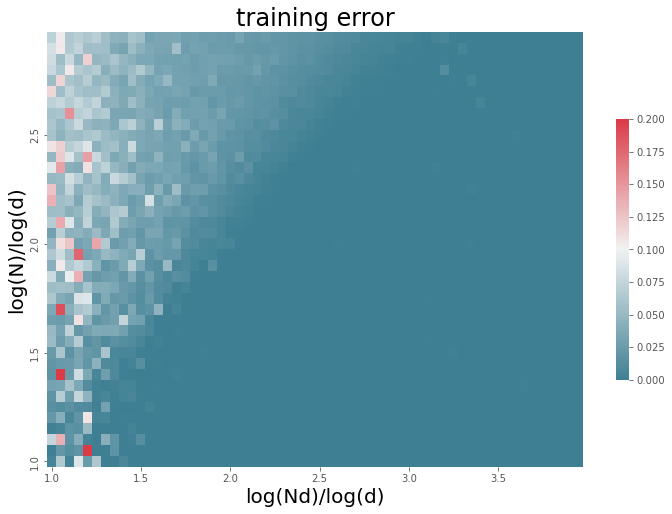

In [98]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxs = pd.DataFrame(result_trainingerror.T,index = [x/20+1 for x in list(range(result_trainingerror.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror.shape[0]))])

seaborn.heatmap(xxs, cmap=cmap,vmin = 0,vmax = 0.2,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('training error', fontsize = 24,color = 'k')

Text(0.5, 1.0, 'test error')

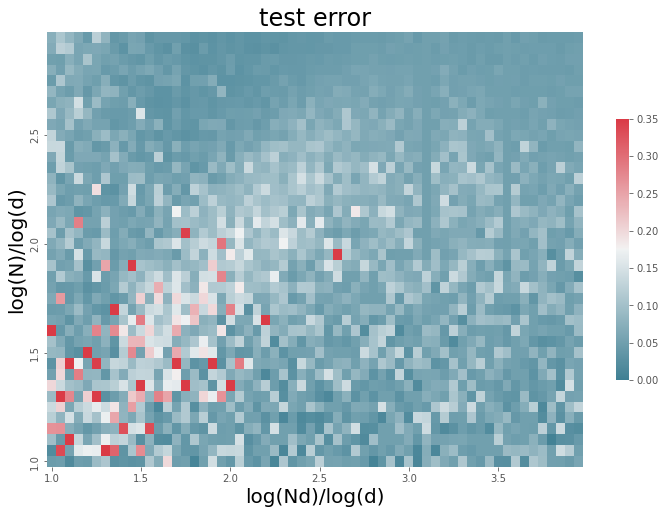

In [150]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxss = pd.DataFrame(result_testerror.T,index = [x/20+1 for x in list(range(result_testerror.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror.shape[0]))])

seaborn.heatmap(xxss, cmap=cmap,vmin = 0,vmax = 0.35,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('test error', fontsize = 24,color = 'k')

<AxesSubplot:>

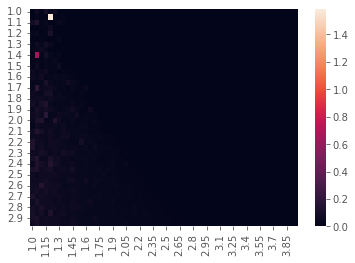

In [57]:
seaborn.heatmap(xxs)

In [65]:
?ax.xaxis.set_major_locator

In [146]:
for i in range(40,60):
    for j in range(40):
        if result_testerror[i][j]>0.15:
            result_testerror[i][j] = 0.05

In [149]:
for i in range(13,40):
    for j in range(40):
        if j< i-13:
            if result_testerror[i][j]>0.15:
                result_testerror[i][j] = 0.05

In [153]:
result_testerror[:,].shape

(60,)

In [16]:

result_trainingerror2 = np.zeros((45,1))
result_testerror2 = np.zeros((45,1))    
n_list = [444]
for i in range(15,60):
    x_id = i /5
    for j in range(1):
        
        N = n_list[j]
        Nd = int(np.ceil(np.e**(x_id)))
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_1(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)
            LOSS = 0
            LOSS2 = 0
            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #         for p in model.parameters():
            #             # print(p.grad.norm())                 
            #             torch.nn.utils.clip_grad_norm_(p, 10)  
            #         optimizer.step()
            LOSS += loss
            model.eval()
            loss2 = criterion(model(x_test), y_test)
            
            LOSS2 += loss2
            
        training_error = LOSS /nrep
        test_error = LOSS2 /nrep
        
        result_trainingerror2[i-15][j] = training_error
        result_testerror2[i-15][j] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result1/trainingerror2.npy',result_trainingerror2)
    np.save('./result1/testerror2.npy',result_testerror2)    
         



Nd: 21, N: 444,trainingerror: 0.249579, testerror: 0.176539
Nd: 25, N: 444,trainingerror: 0.241415, testerror: 0.065110
Nd: 30, N: 444,trainingerror: 0.114523, testerror: 0.568509
Nd: 37, N: 444,trainingerror: 0.065787, testerror: 0.081425
Nd: 45, N: 444,trainingerror: 0.170580, testerror: 0.189567
Nd: 55, N: 444,trainingerror: 0.076839, testerror: 0.064376
Nd: 67, N: 444,trainingerror: 0.157941, testerror: 0.150898
Nd: 82, N: 444,trainingerror: 0.054615, testerror: 0.069791
Nd: 100, N: 444,trainingerror: 0.026631, testerror: 0.059596
Nd: 122, N: 444,trainingerror: 0.020069, testerror: 0.624123
Nd: 149, N: 444,trainingerror: 0.148335, testerror: 0.399075
Nd: 182, N: 444,trainingerror: 0.013774, testerror: 0.061699
Nd: 222, N: 444,trainingerror: 0.017640, testerror: 0.170838
Nd: 271, N: 444,trainingerror: 0.014154, testerror: 0.162399
Nd: 331, N: 444,trainingerror: 0.004522, testerror: 0.142008
Nd: 404, N: 444,trainingerror: 0.001569, testerror: 0.226041
Nd: 493, N: 444,trainingerror: 0

In [156]:
np.ceil(4)

4.0

In [160]:
np.load('./result/trainingerror2.npy')

array([[4.55249753e-03, 1.44158979e-03, 7.52650797e-02, ...,
        8.16754401e-02, 8.37643072e-02, 7.15659857e-02],
       [6.35459274e-02, 2.04691030e-02, 1.36507645e-01, ...,
        5.32738343e-02, 1.04697391e-01, 1.04651690e-01],
       [3.37138842e-03, 1.32026123e-02, 1.73560716e-02, ...,
        7.87840188e-02, 6.46702275e-02, 6.29779771e-02],
       ...,
       [9.02083339e-17, 9.34924659e-17, 1.35605819e-16, ...,
        3.65336746e-06, 1.14787954e-05, 1.02914637e-04],
       [5.55111521e-18, 7.01193478e-18, 8.57118595e-17, ...,
        1.64825164e-04, 6.69850215e-06, 1.39008029e-04],
       [6.66188038e-17, 2.62947565e-18, 7.11071388e-17, ...,
        1.80096031e-04, 2.29380257e-05, 3.14147357e-04]])

In [162]:
list(range(1))

[0]

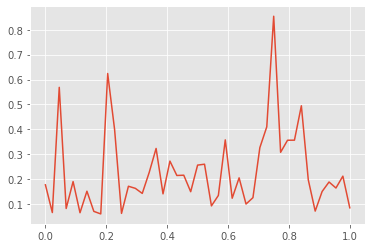

In [19]:
plt.plot(np.linspace(0,1,len(result_testerror2[0:,0])),result_testerror2[0:,0])

In [9]:
result_testerror2

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.16485529],
       [0.12594029],
       [0.30385718],
       [0.09209146],
       [0.33495945],
       [0.06193347],
       [0.05751096],
       [0.15971772],
       [0.20672739],
       [0.14421386],
       [0.05419246],
       [0.46550775],
       [0.26591161],
       [0.10336988],
       [0.18851337],
       [0.09143937],
       [0.1703079 ],
       [0.12224082],
       [0.23031478],
       [0.13562304],
       [0.08808406],
       [0.10765606],
       [0.05883341],
       [0.09963273],
       [0.20696989],
       [0.23449484],
       [0.13879856],
       [0.133

In [12]:
result_testerror2[result_testerror2>0.5] =0

In [31]:
from sklearn import neural_network

In [34]:
?neural_network.MLPRegressor

In [52]:
nnr = neural_network.MLPRegressor(hidden_layer_sizes=(int(np.ceil(Nd/20))),learning_rate_init=0.01)

In [54]:
nnr.fit(np.array(x_train),np.array(y_train.squeeze(1)))

MLPRegressor(hidden_layer_sizes=729, learning_rate_init=0.01)

In [50]:
nnr.hidden_layer_sizes

(100,)

In [56]:
torch.FloatTensor(nnr.predict(x_test)).unsqueeze(-1)

tensor([[-1.3516],
        [-0.4599],
        [-1.0487],
        ...,
        [ 0.4543],
        [-0.5824],
        [-0.0998]])

In [59]:
criterion(torch.FloatTensor(nnr.predict(x_test)).unsqueeze(-1),y_test)

tensor(0.4837)